In [11]:
# data prepare
import glob,re,os,sys
os.chdir('C:/kongjy_special/实习工作内容总结/201805-201808华泰证券/Task4/')
sys.path.append('C:\\kongjy_special\\实习工作内容总结\\201805-201808华泰证券\\Task4')
from matplotlib import pyplot as plt
import pandas as pd
import time
import TranFeature,Tools_kjy
import warnings

warnings.filterwarnings('ignore')
pd.options.display.width = 200

# 文件名
TickNameList = glob.glob('Java_log_orders_600519/Tick*.csv')
TranNameList = glob.glob('Java_log_orders_600519/Tran*.csv')
# TestName是 开平仓点 的csv，需要和Tick以及Tran保持时间对齐
DateList = [re.search('\d{8}',i)[0] for i in TickNameList if re.search('\d{8}',i)]  
TestNameFun = lambda x: "Java_log_orders_600519\\600519.SH_back_test_info_" + x +".csv"
TestNameList = [TestNameFun(i) for i in DateList]
print (TickNameList[0])
print (TranNameList[0])
print (TestNameList[0])

Java_log_orders_600519\Tick20180502.csv
Java_log_orders_600519\Tran20180502.csv
Java_log_orders_600519\600519.SH_back_test_info_20180502.csv


In [12]:
# 数据读入 和 预处理
date_index = 6
date = re.search('\d{8}',TickNameList[date_index])[0]
tempTick = pd.read_csv(TickNameList[date_index])
tempTran = pd.read_csv(TranNameList[date_index])
tempTest = pd.read_csv(TestNameList[date_index])
print (TickNameList[date_index])
print (TranNameList[date_index])
print (TestNameList[date_index])
# Tick数据处理
tempTick = tempTick.rename(columns={"Unnamed: 0":"Timestamp"})
tempTick['Timestamp'] = pd.to_datetime(tempTick['Timestamp'])
tempTick['median_5'] = (tempTick['BidP0'].rolling(window=5).median()).shift(-2).fillna(method='pad')
tempTick['median_5'],_ = Tools_kjy.smooth(tempTick['median_5'])
# 开平仓点提取
tickindex = tempTest[tempTest.order != " "].index
print ("Date : %s"%(date))
# # Tran 数据处理
tempTran = tempTran.rename(columns={"Unnamed: 0":"Timestamp"})
tempTran['Timestamp'] = pd.to_datetime(tempTran['Timestamp'])
FeatureTran = TranFeature.TranFeature(tempTran,tempTick)
tempTick = FeatureTran._Tran_features()

# future change
tempTick['isadd_3Tick'] = tempTick['BidP0'].diff(3).shift(-3).fillna(0).apply(Tools_kjy.trinary)
tempTick['isadd_1Tick'] = tempTick['BidP0'].diff(1).shift(-1).fillna(0).apply(Tools_kjy.trinary)

print (tempTick.iloc[:20,-11:])


Java_log_orders_600519\Tick20180510.csv
Java_log_orders_600519\Tran20180510.csv
Java_log_orders_600519\600519.SH_back_test_info_20180510.csv
Date : 20180510
_drop_Contunous costs 0.071 seconds!
    median_5  LowPrice  HighPrice  MedianPrice  CountPrice  MedianBid  MedianAsk  CountBid  CountAsk  isadd_3Tick  isadd_1Tick
0        NaN    703.50     705.88      703.500       166.0     703.50    705.000      82.0      84.0            2            2
1        NaN    705.50     705.50      705.500         4.0     705.50    705.500       2.0       2.0            2            2
2     705.80    705.51     705.89      705.655         6.0     705.80    705.510       3.0       3.0            2            2
3     705.81    705.81     705.95      705.890        10.0     705.89    705.890       3.0       7.0            0            0
4     705.81    705.81     706.06      705.950        17.0     705.99    705.890       8.0       9.0            2            2
5     705.89    705.98     705.99      705.9

In [14]:
# 下面提取的特征是针对时间序列的
# 盘口等量
tempTran.head()
Tools_kjy.cumsum(tempTick)
Tools_kjy.findequal(tempTick,5)
Tools_kjy.findequal(tempTick,10)
Tools_kjy.findequal(tempTick,15)
Tools_kjy.findequal(tempTick,20)
Tools_kjy.findequal(tempTick,25)
print ('等体量价格因子done')
Tools_kjy.BidAskPower(tempTick,"Bid")
Tools_kjy.BidAskPower(tempTick,"Ask")
tempTick['TRAN_P1_ori'] = (-tempTick['BidStrength'] + tempTick['AskStrength']) 
tempTick['TRAN_P1'] = tempTick['TRAN_P1_ori'].apply(Tools_kjy.trinary)
print ("done")

等体量价格因子done
done


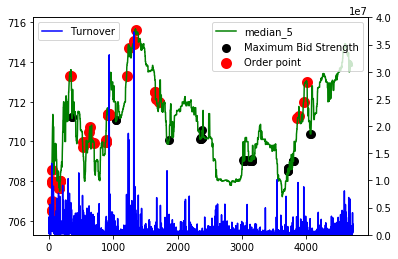

In [15]:
plt.figure(8)
plt.plot(tempTick.median_5[:-10],c='g')
n = int(len(tickindex) / 3)
Ai = tempTick.TRAN_P1_ori.nlargest(n).index                  
# 最大买的强度
plt.scatter(Ai,tempTick.loc[Ai,'median_5'],linewidth=3,c='k',label='Maximum Bid Strength')
# 下单点
plt.scatter(tickindex,tempTick.loc[tickindex,'median_5'],c='r',linewidths=5,label='Order point')
plt.legend(loc=1)

plt.twinx()
plt.plot(tempTick.Turnover ,c='b')
plt.ylim([0,4*1e7])
plt.legend(loc=2)
plt.show()

In [16]:
# 总体下单 的样本分布
print ("总体下单的样本分布，3Tick变化:")
print (tempTick.loc[tickindex,'isadd_1Tick'].value_counts(),'\n')

# 总体下单 的样本分布
print ("总体下单的样本分布，1Tick变化:")
print (tempTick.loc[tickindex,'isadd_3Tick'].value_counts())

总体下单的样本分布，3Tick变化:
1    25
2    19
0    10
Name: isadd_1Tick, dtype: int64 

总体下单的样本分布，1Tick变化:
2    27
0    16
1    11
Name: isadd_3Tick, dtype: int64


In [17]:
# 单Tick 的买卖强度 对价格涨跌的影响
n = int(len(tickindex) / 3)
Ai = tempTick.loc[tickindex,'TRAN_P1_ori'].nlargest(n).index
# 强势买区域
print ("采用1Tick数据，下单点前30个最强势买区域，3Tick后的情况：")
print (tempTick.loc[Ai,'isadd_3Tick'].value_counts(),"\n")
print ("采用1Tick数据，下单点前30个最强势买区域，1Tick后的情况：")
print (tempTick.loc[Ai,'isadd_1Tick'].value_counts(),"\n")
# 强势卖区域
Ai = tempTick.loc[tickindex,'TRAN_P1_ori'].nsmallest(n).index
print ("采用1Tick数据，下单点前30个最强势卖区域，3Tick后的情况：")
print (tempTick.loc[Ai,'isadd_3Tick'].value_counts(),"\n")
print ("采用1Tick数据，下单点前30个最强势卖区域，1Tick后的情况：")
print (tempTick.loc[Ai,'isadd_1Tick'].value_counts())

采用1Tick数据，下单点前30个最强势买区域，3Tick后的情况：
2    11
1     6
0     1
Name: isadd_3Tick, dtype: int64 

采用1Tick数据，下单点前30个最强势买区域，1Tick后的情况：
2    10
1     6
0     2
Name: isadd_1Tick, dtype: int64 

采用1Tick数据，下单点前30个最强势卖区域，3Tick后的情况：
0    8
2    5
1    5
Name: isadd_3Tick, dtype: int64 

采用1Tick数据，下单点前30个最强势卖区域，1Tick后的情况：
1    9
0    7
2    2
Name: isadd_1Tick, dtype: int64


In [18]:
# 6Tick 买卖强度的变化 对价格的影响
tempTick['TRAN_P1_ori_6Tick'] = tempTick['TRAN_P1_ori'].diff(6)
tempTick['TRAN_P1_ori_6Tick'] = tempTick['TRAN_P1_ori_6Tick'] + tempTick['TRAN_P1_ori']
n = int(len(tickindex) / 3)
# 强势买区域
Ai = tempTick.loc[tickindex,'TRAN_P1_ori_6Tick'].nlargest(n).index
print ("采用6Tick数据，下单点前30个最强势买区域，3Tick后的情况：")
print (tempTick.loc[Ai,'isadd_3Tick'].value_counts(),"\n")
print ("采用6Tick数据，下单点前30个最强势买区域，1Tick后的情况：")
print (tempTick.loc[Ai,'isadd_1Tick'].value_counts(),"\n")
# 强势卖区域
Ai = tempTick.loc[tickindex,'TRAN_P1_ori_6Tick'].nsmallest(n).index
print ("采用6Tick数据，下单点前30个最强势卖区域，3Tick后的情况：")
print (tempTick.loc[Ai,'isadd_3Tick'].value_counts(),"\n")
print ("采用6Tick数据，下单点前30个最强势卖区域，1Tick后的情况：")
print (tempTick.loc[Ai,'isadd_1Tick'].value_counts())

采用6Tick数据，下单点前30个最强势买区域，3Tick后的情况：
2    11
1     6
0     1
Name: isadd_3Tick, dtype: int64 

采用6Tick数据，下单点前30个最强势买区域，1Tick后的情况：
2    9
1    8
0    1
Name: isadd_1Tick, dtype: int64 

采用6Tick数据，下单点前30个最强势卖区域，3Tick后的情况：
0    9
2    6
1    3
Name: isadd_3Tick, dtype: int64 

采用6Tick数据，下单点前30个最强势卖区域，1Tick后的情况：
1    9
0    7
2    2
Name: isadd_1Tick, dtype: int64


In [19]:
# 总评，在全局的正确率
tempTick['TRAN_P1'] = tempTick['TRAN_P1_ori'].apply(Tools_kjy.trinary)
tempTick['TRAN_P1_6Tick'] = tempTick['TRAN_P1_ori_6Tick'].apply(Tools_kjy.trinary)
# 单Tick的买卖强度
tempTick['TRAN_P1_3'] = (tempTick.loc[tickindex,'TRAN_P1'] == tempTick.loc[tickindex,'isadd_3Tick']).map({True:1,False:0})
tempTick['TRAN_P1_1'] = (tempTick.loc[tickindex,'TRAN_P1'] == tempTick.loc[tickindex,'isadd_1Tick']).map({True:1,False:0})
print ("采用1Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(tempTick['TRAN_P1_3'].sum()/tempTick['TRAN_P1_3'].count()))
print ("采用1Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(tempTick['TRAN_P1_1'].sum()/tempTick['TRAN_P1_1'].count()))
# 6Tick的买卖强度
tempTick['TRAN_P1_6_3'] = (tempTick.loc[tickindex,'TRAN_P1_6Tick'] == \
                               tempTick.loc[tickindex,'isadd_3Tick']).map({True:1,False:0})
tempTick['TRAN_P1_6_1'] = (tempTick.loc[tickindex,'TRAN_P1_6Tick'] == \
                               tempTick.loc[tickindex,'isadd_1Tick']).map({True:1,False:0})
print ("采用6Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(tempTick['TRAN_P1_6_3'].sum()/tempTick['TRAN_P1_6_3'].count()))
print ("采用6Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(tempTick['TRAN_P1_6_1'].sum()/tempTick['TRAN_P1_6_1'].count()))

采用1Tick数据，所有下单点预测3Tick后的准确率：0.4815
采用1Tick数据，所有下单点预测1Tick后的准确率：0.3333
采用6Tick数据，所有下单点预测3Tick后的准确率：0.4630
采用6Tick数据，所有下单点预测1Tick后的准确率：0.3148


In [20]:
#所有日期 的 准确率
sum_P1_3 = 0
count_P1_3 = 0
sum_P1_1 = 0
count_P1_1 = 0
sum_P1_6_3 = 0
count_P1_6_3 = 0
sum_P1_6_1 = 0
count_P1_6_1 = 0
# 数据读入 和 预处理
for date_index in range(len(TickNameList))[0:]:
    date = re.search('\d{8}',TickNameList[date_index])[0]
    tempTick = pd.read_csv(TickNameList[date_index])
    tempTran = pd.read_csv(TranNameList[date_index])
    tempTest = pd.read_csv(TestNameList[date_index])
    # Tick数据处理
    tempTick = tempTick.rename(columns={"Unnamed: 0":"Timestamp"})
    tempTick['Timestamp'] = pd.to_datetime(tempTick['Timestamp'])
    tempTick['median_5'] = (tempTick['AskP0'].rolling(window=5).median()).shift(-2).fillna(method='pad')
    tempTick['median_5'],_ = Tools_kjy.smooth(tempTick['median_5'])
    # 开平仓点提取
    tickindex = tempTest[tempTest.order != " "].index
    print ("Date : %s"%(date))
    # # Tran 数据处理
    tempTran = tempTran.rename(columns={"Unnamed: 0":"Timestamp"})
    tempTran['Timestamp'] = pd.to_datetime(tempTran['Timestamp'])
    FeatureTran = TranFeature.TranFeature(tempTran,tempTick)
    tempTick = FeatureTran._Tran_features()

    # future change
    tempTick['isadd_3Tick'] = tempTick['BidP0'].diff(3).shift(-3).fillna(0).apply(Tools_kjy.trinary)
    tempTick['isadd_1Tick'] = tempTick['BidP0'].diff(1).shift(-1).fillna(0).apply(Tools_kjy.trinary)
    
    Tools_kjy.cumsum(tempTick)
    Tools_kjy.findequal(tempTick,5)
    Tools_kjy.findequal(tempTick,10)
    Tools_kjy.findequal(tempTick,15)
    Tools_kjy.findequal(tempTick,20)
    Tools_kjy.findequal(tempTick,25)
    Tools_kjy.BidAskPower(tempTick,"Bid")
    Tools_kjy.BidAskPower(tempTick,"Ask")
    tempTick['TRAN_P1_ori'] = (-tempTick['BidStrength'] + tempTick['AskStrength']) 
    tempTick['TRAN_P1'] = tempTick['TRAN_P1_ori'].apply(Tools_kjy.trinary)
    tempTick['TRAN_P1_ori_6Tick'] = tempTick['TRAN_P1_ori'].diff(6)
    tempTick['TRAN_P1_ori_6Tick'] = tempTick['TRAN_P1_ori_6Tick'] + tempTick['TRAN_P1_ori']
    tempTick['TRAN_P1_6Tick'] = tempTick['TRAN_P1_ori_6Tick'].apply(Tools_kjy.trinary)
    # 单Tick的买卖强度
    tempTick['TRAN_P1_3'] = (tempTick.loc[tickindex,'TRAN_P1'] == tempTick.loc[tickindex,'isadd_3Tick']).map({True:1,False:0})
    tempTick['TRAN_P1_1'] = (tempTick.loc[tickindex,'TRAN_P1'] == tempTick.loc[tickindex,'isadd_1Tick']).map({True:1,False:0})
    print ("采用1Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(tempTick['TRAN_P1_3'].sum()/tempTick['TRAN_P1_3'].count()))
    print ("采用1Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(tempTick['TRAN_P1_1'].sum()/tempTick['TRAN_P1_1'].count()))
    # 6Tick的买卖强度
    tempTick['TRAN_P1_6_3'] = (tempTick.loc[tickindex,'TRAN_P1_6Tick'] == \
                                   tempTick.loc[tickindex,'isadd_3Tick']).map({True:1,False:0})
    tempTick['TRAN_P1_6_1'] = (tempTick.loc[tickindex,'TRAN_P1_6Tick'] == \
                                   tempTick.loc[tickindex,'isadd_1Tick']).map({True:1,False:0})
    print ("采用6Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(tempTick['TRAN_P1_6_3'].sum()/tempTick['TRAN_P1_6_3'].count()))
    print ("采用6Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(tempTick['TRAN_P1_6_1'].sum()/tempTick['TRAN_P1_6_1'].count()))
    
    sum_P1_3 += tempTick['TRAN_P1_3'].sum()
    count_P1_3 += tempTick['TRAN_P1_3'].count()
    sum_P1_1 += tempTick['TRAN_P1_1'].sum()
    count_P1_1 += tempTick['TRAN_P1_1'].count()
    sum_P1_6_3 += tempTick['TRAN_P1_6_3'].sum()
    count_P1_6_3 += tempTick['TRAN_P1_6_3'].count()
    sum_P1_6_1 += tempTick['TRAN_P1_6_1'].sum()
    count_P1_6_1 += tempTick['TRAN_P1_6_1'].count()
print ("\n" *2)
print ("#" * 120)
print ("统计所有日期：")
print ("采用1Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(sum_P1_3/count_P1_3))
print ("采用1Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(sum_P1_1/count_P1_1))
# 6Tick的买卖强度
print ("采用6Tick数据，所有下单点预测3Tick后的准确率：%.4f"%(sum_P1_6_3/count_P1_6_3))
print ("采用6Tick数据，所有下单点预测1Tick后的准确率：%.4f"%(sum_P1_6_1/count_P1_6_1))

Date : 20180502
_drop_Contunous costs 0.106 seconds!
采用1Tick数据，所有下单点预测3Tick后的准确率：0.5966
采用1Tick数据，所有下单点预测1Tick后的准确率：0.5714
采用6Tick数据，所有下单点预测3Tick后的准确率：0.4874
采用6Tick数据，所有下单点预测1Tick后的准确率：0.5042
Date : 20180503
_drop_Contunous costs 0.071 seconds!
采用1Tick数据，所有下单点预测3Tick后的准确率：0.5534
采用1Tick数据，所有下单点预测1Tick后的准确率：0.4272
采用6Tick数据，所有下单点预测3Tick后的准确率：0.5728
采用6Tick数据，所有下单点预测1Tick后的准确率：0.4757
Date : 20180504
_drop_Contunous costs 0.090 seconds!
采用1Tick数据，所有下单点预测3Tick后的准确率：0.6636
采用1Tick数据，所有下单点预测1Tick后的准确率：0.5421
采用6Tick数据，所有下单点预测3Tick后的准确率：0.6822
采用6Tick数据，所有下单点预测1Tick后的准确率：0.5701
Date : 20180507
_drop_Contunous costs 0.155 seconds!
采用1Tick数据，所有下单点预测3Tick后的准确率：0.4836
采用1Tick数据，所有下单点预测1Tick后的准确率：0.4508
采用6Tick数据，所有下单点预测3Tick后的准确率：0.4426
采用6Tick数据，所有下单点预测1Tick后的准确率：0.4098
Date : 20180508
_drop_Contunous costs 0.094 seconds!
采用1Tick数据，所有下单点预测3Tick后的准确率：0.6923
采用1Tick数据，所有下单点预测1Tick后的准确率：0.5275
采用6Tick数据，所有下单点预测3Tick后的准确率：0.6593
采用6Tick数据，所有下单点预测1Tick后的准确率：0.5275
Date : 20180509
_drop_Contunous cos